In [ ]:
!pip install pandas -q
!pip install catboost -q
!pip install seaborn -q

In [233]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import openpyxl

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from slugify import slugify
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

# print module versions for reproducibility
# print('CatBoost version {}'.format(cb.__version__))
# print('NumPy version {}'.format(np.__version__))
# print('Pandas version {}'.format(pd.__version__))

In [3]:
# path configurator

path_m = r'C:\\Users\\user\\Desktop\\10\\'
events_by_cat = path_m+'5_Типы событий, регистрируемых по типу объекта многоквартирный дом.xlsx'
work_types_by_support = path_m+'5_Типы событий, регистрируемых по типу объекта многоквартирный дом.xlsx'
work_types_by_cap = path_m+'4_Виды работ по капитальному ремонту многоквартирных домов.xlsx'
works_done = path_m+'3_Работы по капитальному ремонту, проведенные в многоквартирных домах.xlsx'
incidents = path_m+'2_Инциденты,_зарегистрированные_на_объектах_городского_хозяйства.xlsx'
multi_houses_characts = path_m+'1_Многоквартирные дома с технико-экономическими характеристиками.xlsx'

In [4]:
# function to process area
def deffer_area(input_val):
    total_area = 0
    val_total_area = int(float(input_val))
    if val_total_area <= 10:
        total_area = 10
        return total_area
    if val_total_area <= 50:
        total_area = 50
        return total_area
    if val_total_area <= 100:
        total_area = 100
        return total_area
    if val_total_area <= 150:
        total_area = 150
        return total_area
    if val_total_area <= 200:
        total_area = 200
        return total_area
    if val_total_area <= 250:
        total_area = 250
        return total_area
    if val_total_area <= 300:
        total_area = 300
        return total_area
    if val_total_area <= 500:
        total_area = 500
        return total_area
    if val_total_area <= 1000:
        total_area = 1000
        return total_area
    if val_total_area <= 5000:
        total_area = 5000
        return total_area
    if val_total_area <= 10000:
        total_area = 10000
        return total_area
    if val_total_area <= 15000:
        total_area = 15000
        return total_area
    if val_total_area <= 20000:
        total_area = 20000
        return total_area
    if val_total_area <= 25000:
        total_area = 25000
        return total_area
    if val_total_area <= 30000:
        total_area = 30000
        return total_area
    if val_total_area <= 35000:
        total_area = 35000
        return total_area
    if val_total_area <= 40000:
        total_area = 40000
        return total_area
    if val_total_area <= 45000:
        total_area = 45000
    return total_area

# function to preprocess some russian strings to slugs
def slug_me(str_inp):
    if type(str_inp) == str:
        str_inp = str_inp.replace('Российская Федерация, город Москва, ', '')
        if ', к.' in str_inp:
            str_inp = str_inp.split(',')[0:2]
            str_inp = ''.join(str_inp)
        if 'муниципальный округ' in str_inp:
            str_inp = str_inp.split(',')[1:3]
            str_inp = ''.join(str_inp)
        str_inp = str_inp.replace('Дом по адресу ', '')
        str_inp = str_inp.replace('Адрес ', '')
        str_inp = str_inp.replace('дом ', '')
        str_inp = str_inp.replace('район ', '')
        str_inp = str_inp.replace('улица ', '')
        str_inp = str_inp.replace('ул.', '')
        str_inp = str_inp.replace('д.', '')
        str_inp = str_inp.replace(',', '')
        rez = slugify(str_inp, allow_unicode=False, lowercase=True, save_order=True, separator="_")
        return rez
    else:
        rez = 'err'

print(slug_me("Дом по адресу Красковская ул., д.121А"))
print(slug_me("Дом по адресу Рокоссовского Маршала бульв., д.7, к.4"))
print(slug_me("внутригородская территория муниципальный округ Косино-Ухтомский, улица Дмитриевского, дом 5"))
print(slug_me("внутригородская территория муниципальный округ Преображенское, Большая Черкизовская улица, дом 30, корпус 5"))
print(slug_me("Российская Федерация, город Москва, внутригородская территория муниципальный округ Богородское, Краснобогатырская улица, дом 21"))

kraskovskaia_121a
rokossovskogo_marshala_bulv_7
dmitrievskogo_5
bolshaia_cherkizovskaia_30
krasnobogatyrskaia_21


In [5]:
# load xlsx datasets to mem

df_incidents = pd.read_excel(incidents)
df_multi_houses_characts = pd.read_excel(multi_houses_characts)
df_work_types_by_cap = pd.read_excel(work_types_by_cap)
df_events_by_cat = pd.read_excel(events_by_cat)
df_works_done = pd.read_excel(works_done)

In [6]:
# create a tmp dataframes to avoid changing of originals

df_incidents_tmp = df_incidents
df_multi_houses_characts_tmp = df_multi_houses_characts
df_work_types_by_cap_tmp = df_work_types_by_cap
df_events_by_cat_tmp = df_events_by_cat
df_works_done_tmp = df_works_done

# filling NaNs with nulls

df_incidents_tmp = df_incidents_tmp.fillna(0)
df_multi_houses_characts_tmp = df_multi_houses_characts_tmp.fillna(0)
df_work_types_by_cap_tmp = df_work_types_by_cap_tmp.fillna(0)
df_events_by_cat_tmp = df_events_by_cat_tmp.fillna(0)
df_works_done_tmp = df_works_done_tmp.fillna(0)

In [ ]:
print(df_tmp.describe())

## 1_Многоквартирные дома с технико-экономическими характеристиками.xlsx

In [7]:
df_multi_houses_characts_tmp = df_multi_houses_characts_tmp.iloc[1:] # to remove russian captions from ds

names = {
            'COL_754': 'dest', # Назначение
            'COL_756': 'build_year', # Год постройки
            'COL_757': 'reconst_year', # Год реконструкции
            'COL_755': 'ownership', # Форма собственности
            'COL_759': 'floars', # Количество этажей
            'COL_760': 'entrances', # Количество подъездов
            'COL_761': 'apartments', # Количество квартир
            'COL_782': 'unom', # unom
            'COL_758': 'project_series', # Серия проекта
            'COL_762': 'total_area', # Общая площадь
            'COL_763': 'living_area', # Общая площадь жилых помещений
            'COL_764': 'nonliving_area', # Общая площадь нежилых помещений
            'COL_765': 'construction_volume', # Строительный объем
            'COL_766': 'depreciation_object', # Износ объекта (по БТИ)
            'COL_767': 'energyefficiency_class', # Класс энергоэффективности
            'COL_769': 'wall_material', # Материал стен
            'COL_770': 'sign_building_failure', # Признак аварийности здания
            'COL_771': 'passenger_elevators',  # Количество пассажирских лифтов
            'COL_3363': 'freight_elevators', # Количество грузовых лифтов
            'COL_772': 'passenger_freight_elevators', # Количество грузопассажирских лифтов
            'COL_775': 'roof_cleaning', # Очередность уборки кровли
            'COL_2156': 'type_social_object', # Вид социального объекта
            'COL_2463': 'type_housing_stock', # Тип жилищного фонда
            'COL_3163': 'status_MKD', # Статус МКД
            'COL_3243': 'management_status_MKD', # Статус управления МКД
            'COL_3468': 'reason_changing_status_MKD', # Причина Изменения Статуса МКД
            'COL_103506': 'category_MKD', # Категория МКД
         }

# rename column names
df_multi_houses_characts_tmp = df_multi_houses_characts_tmp.rename(columns=names)
df_multi_houses_characts_tmp['NAME'] = df_multi_houses_characts_tmp['NAME'].apply(slug_me)
df_multi_houses_characts_tmp['dest'] = df_multi_houses_characts_tmp['dest'].apply(slug_me)
df_multi_houses_characts_tmp['unom'] = df_multi_houses_characts_tmp['unom'].apply(int)

In [601]:
#df_multi_houses_characts_tmp.head()
df_multi_houses_characts_tmp.shape

(18433, 32)

In [21]:
df_inc['Дата создания во внешней системе']

0         2022-08-30 14:41:53
1         2022-02-20 06:24:07
2         2022-03-07 21:04:01
3         2022-03-05 22:13:33
4         2022-02-18 21:43:54
                  ...        
1048570   2022-11-23 11:56:32
1048571   2022-11-23 15:37:33
1048572   2022-11-24 08:01:52
1048573   2022-11-24 11:56:22
1048574   2022-11-24 12:32:13
Name: Дата создания во внешней системе, Length: 1048575, dtype: datetime64[ns]

In [22]:
df_inc['Дата закрытия']

0         2022-08-30 15:40:26.565
1         2022-04-04 02:43:22.101
2         2022-03-09 09:33:24.894
3         2022-03-05 19:14:00.190
4         2022-02-18 18:44:14.682
                    ...          
1048570   2022-11-23 12:22:34.591
1048571   2022-11-23 16:57:53.149
1048572   2022-11-24 09:08:46.374
1048573   2022-11-24 13:56:41.609
1048574   2022-11-24 12:58:00.838
Name: Дата закрытия, Length: 1048575, dtype: datetime64[ns]

In [139]:
event_counts = df_inc['Наименование'].value_counts()

# Определение минимального количества событий
min_count = event_counts.min()

# Фильтрация событий с минимальным количеством
min_events = event_counts[(event_counts > 1000) & (event_counts < 2000)]

for i, v in min_events.items():
    print(f"'{i}': {v},")

'Повреждение межпанельных швов': 1751,
'Датчик вибрации': 1714,
'Аварийное повреждение лестницы': 1551,
'Повреждение кровли': 1456,
'Блокировка входной двери': 1302,
'Загрязнение/замусоренность козырька': 1239,
'Колодцы, люк занижен': 1157,
'Отсутствие связи': 1086,
'P1 <= 0': 1083,


#### Формирование весов "критичности" для инцидентов

In [201]:
incidents_mos_gas = {
    'Взрыв; Пожар; Задымление': 100,
    'Угроза взрыва': 99,
    'Взрыв': 100,
    'Задымление': 100,
    'Пожар': 100,
    'Нарушение на настенном газопроводе; Запах газа в кухне': 100,
    'Прорыв теплосети (водопровода); Задымление': 100,
    'Гул (шум) на объекте АО МОСГАЗ; Запах газа на улице': 100,
    'Нарушение на настенном газопроводе; Гул (шум, вибрация) от газопровода': 100,    
    'Запах газа в квартире (помещении); Запах газа от газового оборудования': 100,
    'Запах газа в частном доме; Запах газа от газового оборудования': 100,
    'Запах гари в квартире/подъезде': 99,
    'Запах газа из закрытой квартиры': 99,
    'Запах газа от газового оборудования': 79,
    'Нарушение в работе газового оборудования; Слабое горение': 100,
    'Запах газа в доме от АГВ': 100,
    'Не работает АГВ': 100,
    'Хлопок газа; Нарушение в работе газового оборудования': 100,
    'Хлопок газа': 90,
    'Нет газа в квартире': 70,
    'Запах газа в холле и квартире': 100,
    'Запах газа в подъезде и в квартире': 100,
    'Пожар; Запах газа в кухне': 100,
    'Угроза взрыва; Запах газа в доме': 100,
    'Запах газа в котельной': 100,    
    'Запах газа в квартире (помещении); Запах газа на улице; Запах газа в доме': 100,
    'Нарушение на настенном газопроводе; Запах газа в квартире (помещении)': 100,
    'Провал ковера': 100,
    'Неисправность пожарной сигнализации': 89,
    'Проверить настенный газопровод': 70,
    'Запах газа на улице, в подъезде': 70,
    'Запах газа в ванной': 100,
    'Запах газа от газового оборудования; Запах газа в доме': 100,
    'Запах газа от колодца': 100,
    'Пожар; Обрушение': 100,
    'Запах газа в квартире с улицы': 100,
    'просел ковер': 60,
    'Занижен  газ/ковер': 60,
    'Загазованность крана № Г2 40162 2,6%': 100,
    'Нет газа в кваптире': 100,
    'Запах газа в кухне и в холле': 100,
    'Повреждение плиточного/брусчатого покрытия': 20,
    'Запах газа в подъезде и квартире': 100,
    'Поврежден настенный газопровод': 100,
    'Запах  газа  на  улице и в подъезде': 100,
    'Завышено давление газа': 100,
    'Нарушение в работе газового оборудования; Нет газа': 100,
    'Занижен ковер м/г': 100,
    'Нет газа по стояку': 100,
    'Гремят крышки коверов': 100,
    'Открата крышка ковера': 60,
    'Нарушение в работе АОГВ': 100,
    'Запах газа в частном доме': 100,
    'Запах в подъезде': 100,
    'Запах газа у АГВ': 60,
    'Гул (шум, вибрация) от газопровода': 50,
    'Нет газа': 60,
    'Нет  газа в квартире': 70,
    'Пожар; Запах газа в квартире (помещении)': 100,
    'Запах газа в коллекторе': 100,
    'Запах газа в туалете': 100,
    'Запах газа в квартире (помещении); Запах газа в доме': 100,
    'Нарушение в работе газового оборудования; Запах газа в кухне': 100,
    'Проверить квартиру после пожара': 70,
    'Гул (шум) на объекте АО МОСГАЗ': 70,
    'Провис настенный газопровод': 80,
    'Запах газа на улице и в квартире': 90,
    'Запах газа в кухне от стояка': 90,
    'Взрыв; Пожар': 99,
    'Запах газа от настенного газопровода': 99,
    'Нет  газа': 80,
    'Задымление в подъезде': 90,
    'Запах газа из подвала': 99,
}


incidents_water = {
    'Не работает колонка.': 70,
    'Восстановление трубопровода, прочее': 100,
    'Нарушение подачи воды, нет воды в ЦТП': 100,
    'Отсутствует крышка люка': 60,
    'Нарушение в работе АОГВ': 100,
    'Прорыв теплосети (водопровода); Открыт колодец': 100,
    'Утечка воды из земли, поступает в канализацию/водосток': 40,
    'Утечка воды из-под асфальта, поступает в канализацию/водосток': 20,
    'Провал грунта': 40,
    'Колодцы на проезжей части, открыт колодец': 70,
    'Провал, промоина': 70,
    'Аварийная протечка труб в подъезде': 80,
    'Утечка воды, течет спец. вывод': 60,
    'Протечка труб в подъезде': 84,
    'Провал асфальтобетонного покрытия': 70,
    'Провал на проезжей части': 90,
    'Аварийное повреждение лестницы': 90,
    'Нарушение подачи воды, нет воды на верхних этажах': 60,
    'Утечка воды из колодца, поступает в канализацию/водосток': 8,
    'Открыт колодец на проезжей части': 80,
    'Повреждение подъемной платформы для инвалидов': 50,
    'Открыт колодец; Провал': 70,
    'Колодцы на проезжей части, люк занижен': 30,
    'Задымление в подъезде': 90,
    'Запах газа из подвала': 99,
    'Подтопление, вода поступает в городской коллектор (извне)': 30,
    'Подтопление сооружений метрополитена': 99,
    'Запах газа в кухне; Запах газа в квартире (помещении)': 99,
    'Подтопление, повреждение водопровода во внутриквартальном коллекторе': 45,
    'Провал плиточного/брусчатого покрытия': 30,
    'Просадка асфальта вокруг колодца': 30,
    'Открыт колодец МГ': 40,
    'Занижен колодец': 10,
    'Подтопление строений': 78,
    'Температура в помещении общего пользования ниже нормативной': 76,
    'Аномальное значение температуры в подающем трубопроводе': 88,
    'Просадка асфальта( колодец)': 20,
    'Колодцы, нет люка и крышки': 30,
    'Отсутствует крышка колодца': 40,
    'Колодцы на проезжей части, провал колодца': 60,
    'Засоры, прочее': 20,
    'Утечка воды из-под асфальта, поступает на проезжую часть': 60,
    'Утечка воды из земли, поступает на проезжую часть': 60,
    'Качество воды - окрашенная вода': 25,
    'Качество воды - мутная вода': 25,
    'Качество воды - ржавая вода': 25,
    'Качество воды - вода с запахом': 33,
    'Слабое горение': 25,
    'Течь в системе отопления': 70,
    'Сильная течь в системе отопления': 82,
    'Нарушение подачи воды, нет воды в здании': 37,
    'Повреждение асфальтобетонного покрытия': 16,
    'Подтопление, вода поступает в котлован строителей': 60,
    'Провал грунта вокруг ковера': 45,
    'Колодцы, люк на боку': 40,
    'Загрязнение входной двери': 5,
    'Загрязнение окна в местах общего пользования': 25,
    'Загрязнение/замусоренность подвала/полуподвала': 44,
    'Открыт колодец':25,
    'Отклонение ГВС ниже нормы ночью (мониторинг)':76,
    'Отклонение ГВС ниже нормы днем (мониторинг)':75,
    'Температура ГВС ниже нормы':60,
    'Отсутствует циркуляция ГВС':60,
    'Критичное отклонение температуры ГВС ниже нормы днем (мониторинг)':90,
    'Низкий уровень сигнала GSM':25,
    'Нет связи с ПУ':70,
    'Отсутствуют актуальные суточные значения':20,
    'Отсутствуют актуальные мгновенные значения':20,
    'Критичное отклонение температуры ГВС ниже нормы ночью (мониторинг)':91,
    'Нет питания УСПД':65,
    'Открыт шкаф УСПД':25,
    'Нет связи с УСПД':35,
    'Угроза взрыва':99,
    'Отсутствие освещения в местах общего пользования':10,
    'Загрязнение/замусоренность подъезда':10,
    'Повреждение системы электропроводки/щитового оборудования':99,
    'Повреждение отделочных покрытий пола/стены/ступеней/перил/других элементов':10,
    'Загрязнение воды':90,
    'Повреждение элементов входной двери':70,
    'Повреждение элементов фасада':70,
    'Отсутствие ХВС в доме':80,
    'Загрязнение лифта':70,
    'Неочищенная кровля':20,
    'Засор мусоропровода':81,
    'Неисправность запирающего устройства':11,
    'Отсутствие освещения в лифте':81,
    'Неудовлетворительное техническое содержание мусоропровода':41,
    'Лифт требует ремонта':31,
    'Аномальное значение разницы температур':71,
    'Засоры, засор на дворовой сети':21,
    'Температура в квартире ниже нормативной':71,
    'Недогрев ГВС':21,
    'Поломка освещения перед подъездом':11,
    'Поломка лифта':90,
    'Повреждение межпанельных швов':80,
    'Наличие крыс/мышей/насекомых в местах общего пользования':71,
    'Засор канализации':91,
    'Повреждение внутренней двери':21,
    'Отсутствие связи':41,
    'Датчик вибрации':21,
    'Протечка труб в подъезде':61,
    'Повреждение кровли':70,
    'Повреждение козырька подъезда':91,
    'Утечка воды из земли, прочее':77,
    'Сильная течь в системе отопления':89,
    'Поломка почтовых ящиков':5,
    'Подтопление строений':61,
    'Утечка воды, прочее':31,
    'Загрязнение/замусоренность козырька':21,
    'Повреждение инженерных сетей':41,
    'Разбито/сломано/повреждено окно в местах общего пользования':31,
    'Подтопление, течь трубопровода на водомерном узле':65,
    'Протечка в подъезде':61,
    'Несовпадение серийного номера ПУ на УСПД':21,
    'Подтопление, повреждение водопровода во внутриквартальном коллекторе':65,
    'Застревание в лифте':90,
    'Открыт колодец на газоне':60,
    'Колодцы, прочее':55,
    'Протечка с кровли':80,
    'Аварийная протечка в подъезде':80,
    'Аварийная протечка с кровли':80,
    'Загрязнение окна в местах общего пользования':11,
    'Загрязнение отделочных покрытий':11,
    'Неудовлетворительное санитарное содержание мусоропровода':11,
    'Утечка воды, течет водопроводная колонка или подводка':30,
    'Отсутствие отопления в доме':35,
    'Температура в помещении общего пользования ниже нормативной':11,
    'Задымление':99,
    'Отрицательные интегральные значения':6,
    'Аномальное значение времени наработки':10,
    'Повреждение пола/стены/ступеней/перил/других элементов':50,
    'Блокировка входной двери':60,
    'Течь в системе отопления':80,
    'Провал на проезжей части':80,
    'Прорыв теплосети (водопровода)':80,
    'Утечка воды из колодца, прочее':50,
    'Протечка с балкона/козырька':11,
    'Неисправность пожарной сигнализации':76,
}

In [357]:
# присваивание весов "критичности" к источникам инцидентов
def set_source_priority(name_source: str):
    match name_source:
        case 'ASUPR': return 0.1
        case 'CAFAP': return 0.3
        case 'EDC': return 0.3
        case 'EVAGD': return 0.2
        case 'GORMOST': return 0.2
        case 'KGH': return 0.6
        case 'MGI': return 0.5
        case 'MOS_GAS': return 1.0
        case 'MVK': return 0.1
        case 'NG': return 0.3


df = df_incidents
df = df.rename(columns={
    "Наименование":"name", 
    "Дата создания во внешней системе":"date_system_start", 
    "Дата закрытия":"date_end", 
    "Дата и время завершения события во":"date_system_end", 
    "Округ":"area", 
    "Источник": "source",
    "Адрес":"address", 
    })

df[['date_system_start', 'date_system_end', 'date_end']] =df[['date_system_start', 'date_system_end', 'date_end']].apply(pd.to_datetime)

df['date_system_end'] = np.where(df['date_system_end'].isna(), df['date_end'], df['date_system_end'])
df = df.drop(['area', 'date_end', 'address'], axis=1)

df['source_priority'] = df['source'].apply(lambda x: set_source_priority(x))

df['delta_time_in_seconds'] = df['date_system_end'] - df['date_system_start']
df['delta_time_in_seconds']=df['delta_time_in_seconds'].astype('int64') // 10**9
df_only_instance = df[['name', 'source', 'delta_time_in_seconds', 'source_priority']]
df_only_instance.loc[df_only_instance['delta_time_in_seconds'] <= 0, ['delta_time_in_seconds']] = 1
df_only_instance.loc[:,['incident_prority']] =  df_only_instance['delta_time_in_seconds'] / df_only_instance['delta_time_in_seconds'].max()
df_only_instance = df_only_instance.drop(['delta_time_in_seconds'], axis=1)
df_only_instance['priority'] = df_only_instance['incident_prority'] * df_only_instance['source_priority']
df_only_instance.sort_values(by=['priority'])

df_only_instance = df_only_instance.drop(['incident_prority', 'source_priority'], axis=1)
df_only_instance.sort_values(by=['priority'])

df_result = df_only_instance.groupby(by=['name', 'source'], as_index=False).mean()
df_result = df_result.sort_values(by=['priority'], ascending=[False]).reset_index(drop=True)
df_result

words_coef = {
    5 : ['пожар','хлопок','взрыв', 'затоплен', 'дым', 'газ'],
}
for coef in words_coef.keys():
    for word in words_coef[coef]:
        # print(f"{coef} - {word}")
        df_result.loc[df_result['name'].str.contains(word),['priority']] *= coef 

df_result.loc[:,['priority']] = df_result['priority'] / df_result['priority'].max()
df_result


#df_result.sort_values(by=['priority'], ascending=[False]).to_excel('incident_priority.xlsx', index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


name   source      priority
0    Запах газа в квартире (помещении); Запах газа ...  MOS_GAS  1.000000e+00
1                                      Занижен колодец  MOS_GAS  1.883773e-01
2                      Запах газа на улице, в подъезде  MOS_GAS  9.045453e-01
3                                 Запах газа от стояка  MOS_GAS  7.331174e-01
4                     Запах газа на улице и в подъезде  MOS_GAS  7.210037e-01
..                                                 ...      ...           ...
354  Нарушение в работе газового оборудования; Слаб...  MOS_GAS  8.222884e-06
355  Гул (шум) на объекте АО МОСГАЗ; Запах газа на ...  MOS_GAS  8.222884e-06
356                   Угроза взрыва; Запах газа в доме  MOS_GAS  2.046160e-05
357     Прорыв теплосети (водопровода); Открыт колодец  MOS_GAS  7.649195e-09
358                                   Перекрытие полос  GORMOST  1.529839e-09

[359 rows x 3 columns]

### Предсказание времнеи старта и окончания плановых работ

In [354]:
from sklearn.linear_model import LinearRegression
from datetime import datetime

data = df_works_done

data['planned_date_start'] = pd.to_datetime(df_works_done['PLAN_DATE_START'], dayfirst=True)
data['planned_date_end'] = pd.to_datetime(df_works_done['PLAN_DATE_END'], dayfirst=True)
data['fact_date_start'] = pd.to_datetime(df_works_done['FACT_DATE_START'], dayfirst=True)
data['fact_date_end'] = pd.to_datetime(df_works_done['FACT_DATE_START'], dayfirst=True)

# создание дельт времени
data['time_difference_start'] = (data['fact_date_start'] - data['planned_date_start']).dt.total_seconds()
data['time_difference_end'] = (data['fact_date_end'] - data['planned_date_end']).dt.total_seconds()

# преобразование дат в числовые значения
data['planned_date_start_numeric'] = (data['planned_date_start'] - datetime(1970, 1, 1)).dt.total_seconds()
data['planned_date_end_numeric'] = (data['planned_date_end'] - datetime(1970, 1, 1)).dt.total_seconds()

# выбор необходимых параметров для регрессии
selected_features = ['planned_date_start_numeric', 'planned_date_end_numeric']
X = data[selected_features].values  

# создание вектора переменной для старта работ
y_start = data['time_difference_start'].values

# модель лин. регрессии
model_start = LinearRegression()
model_start.fit(X, y_start)

# создание вектора переменной для окончания работ
y_end = data['time_difference_end'].values

# модель лин. регрессии
model_end = LinearRegression()
model_end.fit(X, y_end)

# пример предсказания для нового случая
new_planned_start = datetime.strptime('28.08.2022', '%d.%m.%Y')
new_planned_end = datetime.strptime('14.10.2022', '%d.%m.%Y')

new_planned_start_numeric = (new_planned_start - datetime(1970, 1, 1)).total_seconds()
new_planned_end_numeric = (new_planned_end - datetime(1970, 1, 1)).total_seconds()

new_planned_date = pd.DataFrame({'planned_date_start_numeric': [new_planned_start_numeric], 'planned_date_end_numeric': [new_planned_end_numeric]})

predicted_difference_start = model_start.predict(new_planned_date)
predicted_difference_end = model_end.predict(new_planned_date)

# планируемые  даты старта и окончания работ
planned_start_date = pd.to_datetime('2022-08-28', format='%Y-%m-%d')
planned_end_date = pd.to_datetime('2022-10-14', format='%Y-%m-%d')

# постпроцесс времени в нормальный вид даты
predicted_start_date = planned_start_date + pd.Timedelta(seconds=predicted_difference_start[0])
predicted_end_date = planned_end_date + pd.Timedelta(seconds=predicted_difference_end[0])

# предсказание
print('Предсказанное время старта работ:', predicted_start_date)
print('Предсказанное время окончания работ:', predicted_end_date)

Предсказанное время старта работ: 2022-07-04 02:24:39.641382396
Предсказанное время окончания работ: 2022-07-04 02:24:39.641382039


X has feature names, but LinearRegression was fitted without feature names
X has feature names, but LinearRegression was fitted without feature names


## 2_Инциденты,_зарегистрированные_на_объектах_городского_хозяйства.xlsx

In [8]:
df_inc = df_incidents_tmp
df_inc['Дата создания во внешней системе'] = pd.to_datetime(df_incidents['Дата создания во внешней системе'], errors='coerce')
df_inc['Дата закрытия'] = pd.to_datetime(df_incidents['Дата закрытия'], errors='coerce')

df_incidents_tmp['time_delta'] = (df_incidents_tmp['Дата закрытия'] - df_incidents_tmp['Дата создания во внешней системе']) / np.timedelta64(1, 'D')

names = {
            'Наименование': 'incident_name', # Наименование
            'Источник': 'source', # Источник
            'Дата создания во внешней системе': 'external_create_date', # Дата создания во внешней системе
            'Дата закрытия': 'close_date', # Дата закрытия
            'Адрес': 'address', # Адрес
            'Округ': 'district', # Округ
            'Дата и время завершения события во': 'done_date', # Дата и время завершения события во
         }

# rename column names
df_incidents_tmp = df_incidents_tmp.rename(columns=names)

# sluglify names of incidents, addresses and districts
#df_incidents_tmp['incident_name'] = df_incidents_tmp['incident_name'].apply(slug_me)
df_incidents_tmp['address'] = df_incidents_tmp['address'].apply(slug_me)
df_incidents_tmp['district'] = df_incidents_tmp['district'].apply(slug_me)

# prepare date format
df_incidents_tmp['external_create_date'] = pd.to_datetime(df_incidents_tmp['external_create_date'], errors='coerce')
df_incidents_tmp['external_create_date_year'] = df_incidents_tmp['external_create_date'].dt.year
df_incidents_tmp['external_create_date_month'] = df_incidents_tmp['external_create_date'].dt.month
df_incidents_tmp['external_create_date_day'] = df_incidents_tmp['external_create_date'].dt.day
df_incidents_tmp['done_date'] = pd.to_datetime(df_incidents_tmp['done_date'], errors='coerce')
df_incidents_tmp['done_date_year'] = df_incidents_tmp['done_date'].dt.year
df_incidents_tmp['done_date_month'] = df_incidents_tmp['done_date'].dt.month
df_incidents_tmp['done_date_day'] = df_incidents_tmp['done_date'].dt.day
df_incidents_tmp['close_date'] = pd.to_datetime(df_incidents_tmp['close_date'], errors='coerce')
df_incidents_tmp['close_date_year'] = df_incidents_tmp['close_date'].dt.year
df_incidents_tmp['close_date_month'] = df_incidents_tmp['close_date'].dt.month
df_incidents_tmp['close_date_day'] = df_incidents_tmp['close_date'].dt.day

# remove unnecsessary
df_incidents_tmp.drop('external_create_date', axis=1, inplace=True)
df_incidents_tmp.drop('close_date', axis=1, inplace=True)
df_incidents_tmp.drop('done_date', axis=1, inplace=True)
df_incidents_tmp.drop('district', axis=1, inplace=True)
df_incidents_tmp.drop('address', axis=1, inplace=True)

In [691]:
df_incidents_tmp.shape

(1048575, 13)

## 3_Работы по капитальному ремонту, проведенные в многоквартирных домах.xlsx

In [9]:
# prepare date format
df_works_done_tmp['PLAN_DATE_START'] = pd.to_datetime(df_works_done_tmp['PLAN_DATE_START'], dayfirst=True)
df_works_done_tmp['PLAN_DATE_START_year'] = df_works_done_tmp['PLAN_DATE_START'].dt.year
df_works_done_tmp['PLAN_DATE_START_month'] = df_works_done_tmp['PLAN_DATE_START'].dt.month
df_works_done_tmp['PLAN_DATE_START_day'] = df_works_done_tmp['PLAN_DATE_START'].dt.day

df_works_done_tmp['PLAN_DATE_END'] = pd.to_datetime(df_works_done_tmp['PLAN_DATE_END'], dayfirst=True)
df_works_done_tmp['PLAN_DATE_END_year'] = df_works_done_tmp['PLAN_DATE_END'].dt.year
df_works_done_tmp['PLAN_DATE_END_month'] = df_works_done_tmp['PLAN_DATE_END'].dt.month
df_works_done_tmp['PLAN_DATE_END_day'] = df_works_done_tmp['PLAN_DATE_END'].dt.day

df_works_done_tmp['FACT_DATE_START'] = pd.to_datetime(df_works_done_tmp['FACT_DATE_START'], dayfirst=True)
df_works_done_tmp['FACT_DATE_START_year'] = df_works_done_tmp['FACT_DATE_START'].dt.year
df_works_done_tmp['FACT_DATE_START_month'] = df_works_done_tmp['FACT_DATE_START'].dt.month
df_works_done_tmp['FACT_DATE_START_day'] = df_works_done_tmp['FACT_DATE_START'].dt.day

df_works_done_tmp['FACT_DATE_END'] = pd.to_datetime(df_works_done_tmp['FACT_DATE_END'], dayfirst=True)
df_works_done_tmp['FACT_DATE_END_year'] = df_works_done_tmp['FACT_DATE_END'].dt.year
df_works_done_tmp['FACT_DATE_END_month'] = df_works_done_tmp['FACT_DATE_END'].dt.month
df_works_done_tmp['FACT_DATE_END_day'] = df_works_done_tmp['FACT_DATE_END'].dt.day

df_works_done_tmp['unom'] = df_works_done_tmp['UNOM']

# remove unnecsessary
df_works_done_tmp.drop('PLAN_DATE_START', axis=1, inplace=True)
df_works_done_tmp.drop('PLAN_DATE_END', axis=1, inplace=True)
df_works_done_tmp.drop('FACT_DATE_END', axis=1, inplace=True)
df_works_done_tmp.drop('FACT_DATE_START', axis=1, inplace=True)
df_works_done_tmp.drop('Address', axis=1, inplace=True)

# sluglify names
#df_works_done_tmp['WORK_NAME'] = df_works_done_tmp['WORK_NAME'].apply(slug_me)
df_works_done_tmp['AdmArea'] = df_works_done_tmp['AdmArea'].apply(slug_me)
df_works_done_tmp['District'] = df_works_done_tmp['District'].apply(slug_me)
#df_works_done_tmp['Address'] = df_works_done_tmp['Address'].apply(slug_me)

In [693]:
df_works_done_tmp.shape

(1747, 21)

In [694]:
df_works_done_tmp['WORK_NAME'].unique()

array(['замена лифтового оборудования',
       'ремонт внутридомовых инженерных систем водоотведения (канализации) (выпуски и сборные трубопроводы)',
       'ремонт внутридомовых инженерных систем теплоснабжения (разводящие магистрали)',
       'ремонт внутридомовых инженерных систем холодного водоснабжения (разводящие магистрали)',
       'ремонт внутридомовых инженерных систем горячего водоснабжения (разводящие магистрали)',
       'ремонт подвальных помещений, относящихся к общему имуществу в многоквартирном доме',
       'ремонт внутридомовых инженерных систем газоснабжения',
       'ремонт подъездов, направленный на восстановление их надлежащего состояния и проводимый при выполнении иных работ по капитальному ремонту общего имущества в многоквартирном доме',
       'ремонт фасадов', 'ремонт крыши',
       'ремонт внутридомовых инженерных систем электроснабжения',
       'ремонт мусоропровода',
       'замена оконных блоков, расположенных в помещениях общего пользования',
       'р

## 4_Виды работ по капитальному ремонту многоквартирных домов.xlsx

In [221]:
df_work_types_by_cap_tmp = df_work_types_by_cap_tmp.iloc[1:] # to remove russian captions from ds

names = {
            df_work_types_by_cap_tmp.columns[0]: 'index', # №\nп/п
            df_work_types_by_cap_tmp.columns[1]: 'code', # Код
            df_work_types_by_cap_tmp.columns[2]: 'work_name', # Наименование 	
            df_work_types_by_cap_tmp.columns[3]: 'owner_name', # Наименование объекта общего имущества
            df_work_types_by_cap_tmp.columns[4]: 'work_type', # Тип работ
            df_work_types_by_cap_tmp.columns[5]: 'work_group', # Группа работ
            df_work_types_by_cap_tmp.columns[6]: 'slug_work', # Сокращенное наименование работы
         }

# rename column names
df_work_types_by_cap_tmp = df_work_types_by_cap_tmp.rename(columns=names)
#df_work_types_by_cap_tmp['work_name'] = df_work_types_by_cap_tmp['work_name'].apply(slug_me)
#df_work_types_by_cap_tmp['owner_name'] = df_work_types_by_cap_tmp['owner_name'].apply(slug_me)
#df_work_types_by_cap_tmp['work_type'] = df_work_types_by_cap_tmp['work_type'].apply(slug_me)
#df_work_types_by_cap_tmp['work_group'] = df_work_types_by_cap_tmp['work_group'].apply(slug_me)
#df_work_types_by_cap_tmp['slug_work'] = df_work_types_by_cap_tmp['slug_work'].apply(slug_me)

In [11]:
df_work_types_by_cap_tmp

index code                                          work_name  \
1      1  105                              строительный контроль   
2      2   26  ремонт подъездов, направленный на восстановлен...   
3      3    9  ремонт фасада (замена оконных блоков, располож...   
4      4  104  проведение экспертизы проектной документации п...   
5      5   20                  разработка проектной документации   
6      6    3  ремонт внутридомовых инженерных систем теплосн...   
7      7    5  ремонт внутридомовых инженерных систем водоотв...   
8      8    4  ремонт внутридомовых инженерных систем горячег...   
9      9    4  ремонт внутридомовых инженерных систем холодно...   
10    10   53                    ремонт или замена мусоропровода   
11    11   52                       ремонт пожарного водопровода   
12    12   51  ремонт внутридомовой системы дымоудаления и пр...   
13    13    1  ремонт внутридомовых инженерных сетей электрос...   
14    14    2  ремонт внутридомовых инженерных систем газосна...   
15    15    9  ремонт подвальных помещений, относящихся к общ...   
16    16    3  ремонт внутридомовых инженерных систем теплосн...   
17    17    5  ремонт внутридомовых инженерных систем водоотв...   
18    18    4  ремонт внутридомовых инженерных систем горячег...   
19    19   11                                  ремонт фундамента   
20    20    4  ремонт внутридомовых инженерных систем холодно...   
21    21    8                                       ремонт крыши   
22    22   12            ремонт или замена внутреннего водостока   
23    23   13                                    ремонт балконов   
24    24   10                                      ремонт фасада   
25    25  333                         оценка соответствия лифтов   
26    26   28  Разработка и проведение экспертизы ПД, в том ч...   
27    27  106                                   Авторский надзор   
28    28  321        разработка проектной документации по лифтам   
29    29    6                      замена лифтового оборудования   

                                           owner_name work_type  \
1                               Строительный контроль    Услуга   
2                                             Подъезд    Работа   
3                                Фасад(оконные блоки)    Работа   
4                               проведение экспертизы    Услуга   
5                   разработка проектной документации    Услуга   
6        Внутридомовые системы отопления (магистрали)    Работа   
7      Внутридомовые системы канализации (магистрали)    Работа   
8   Внутридомовые инженерные системы горячего водо...    Работа   
9   Внутридомовые системы холодного водоснабжения ...    Работа   
10                                       Мусоропровод    Работа   
11                                Пожарный водопровод    Работа   
12                               Системы дымоудаления    Работа   
13             Внутридомовые системы электроснабжения    Работа   
14     Внутридомовые инженерные системы газоснабжения    Работа   
15  Подвальные помещения, относящиеся к общему иму...    Работа   
16           Внутридомовые системы отопления (стояки)    Работа   
17         Внутридомовые системы канализации (стояки)    Работа   
18  Внутридомовые инженерные системы горячего водо...    Работа   
19                                          Фундамент    Работа   
20  Внутридомовые системы холодного водоснабжения ...    Работа   
21                                              Крыша    Работа   
22                                Внутренний водосток    Работа   
23                                    Фасад (балконы)    Работа   
24                                              Фасад    Работа   
25                         оценка соответствия лифтов    Услуга   
26  Разработка и проведение экспертизы ПД, в том ч...    Работа   
27                                   Авторский надзор    Услуга   
28        разработка проектной документации по лифтам    Услуга   
29                 

### Предиктим дату закрытия заявки

In [695]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle 

# Определение входных признаков и целевой переменной
df_incidents_tmp = df_incidents_tmp.fillna(0)
X = df_incidents_tmp[['external_create_date_month', 'time_delta', 'external_create_date_day', 'close_date_month', ]]
y = df_incidents_tmp['close_date_day']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# прогнозирование даты фактического события
y_pred = model.predict(X_test)

# оценка качества преликта
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

filename = 'close_date_day_model.sav'
pickle.dump(model, open(filename, 'wb'))

Mean Squared Error: 18.547533160732648


### Объединяем датасет выполненных и инцидентов с характеристиками об объектах

In [234]:
df_merged = df_incidents_tmp.merge(df_multi_houses_characts_tmp, on='unom', how='left')

### Объединяем датасет выполненных работ с инцидентами

In [235]:
df_merged = df_merged.merge(df_works_done_tmp, on='unom', how='left')

In [14]:
df_merged.columns

Index(['incident_name', 'source', 'unom', 'time_delta',
       'external_create_date_year', 'external_create_date_month',
       'external_create_date_day', 'done_date_year', 'done_date_month',
       'done_date_day', 'close_date_year', 'close_date_month',
       'close_date_day', 'ID', 'NAME', 'PARENT_ID', 'LOGIN', 'dest',
       'ownership', 'build_year', 'reconst_year', 'project_series', 'floars',
       'entrances', 'apartments', 'total_area', 'living_area',
       'nonliving_area', 'construction_volume', 'depreciation_object',
       'energyefficiency_class', 'wall_material', 'sign_building_failure',
       'passenger_elevators', 'passenger_freight_elevators', 'roof_cleaning',
       'COL_781', 'type_social_object', 'type_housing_stock', 'status_MKD',
       'management_status_MKD', 'freight_elevators',
       'reason_changing_status_MKD', 'category_MKD', 'global_id', 'PERIOD',
       'WORK_NAME', 'NUM_ENTRANCE', 'ElevatorNumber', 'AdmArea', 'District',
       'UNOM', 'PLAN_DATE_S

In [699]:
df_merged.shape

(1489971, 64)

In [20]:
df_merged['time_delta'][:20]

0      0.040666
1     42.846703
2      1.520415
3     -0.124685
4     -0.124761
5      0.208001
6      0.041712
7     -0.124761
8      0.069803
9      1.542556
10     0.090027
11     0.124138
12    -0.124836
13    -0.000235
14    -0.124846
15    -0.124489
16     0.082972
17     0.041477
18     0.522798
19     0.068860
Name: time_delta, dtype: float64

In [236]:
df_merged = df_merged.fillna(0)

In [ ]:
incs = df_merged['incident_name'].unique()
i = 0
for inc in incs:
    print(f"'{inc}':111,")
    i += 1
    if i > 100:
        break

In [263]:
event_counts = df_inc['Наименование'].value_counts()
event_counts.head(25)

Отсутствуют актуальные мгновенные значения                   137998
Температура в квартире ниже нормативной                       95025
Отсутствие освещения в местах общего пользования              65588
Отсутствуют актуальные суточные значения                      46652
Нет питания УСПД                                              42068
Нет связи с ПУ                                                40834
Низкий уровень сигнала GSM                                    38077
Лифт требует ремонта                                          37648
Температура ГВС ниже нормы                                    37206
Отсутствие ГВС в доме                                         35408
Загрязнение/замусоренность подъезда                           34161
Отсутствует циркуляция ГВС                                    32912
Нет связи с УСПД                                              30501
Повреждение элементов входной двери                           26442
Недогрев ГВС                                    

In [206]:
# Фильтрация и сортировка записей
filtered_df = df_merged[(df_merged['build_year'].apply(int) < 2000) &
                 (df_merged['incident_name'].map(incidents_mos_gas) == max(incidents_mos_gas.values()))]

filtered_df.head(10)

incident_name   source     unom  time_delta  external_create_date_year  \
1607          Пожар  MOS_GAS  2401770    0.000368                       2022   
2747          Пожар  MOS_GAS     4120  176.742187                       2022   
3021     Задымление  MOS_GAS     8412  224.947852                       2022   
5527          Пожар  MOS_GAS    24034    0.000582                       2022   
5788     Задымление  MOS_GAS    19222  137.624457                       2022   
8864          Пожар  MOS_GAS    24429  138.027838                       2022   
15395         Пожар  MOS_GAS    19970    0.000421                       2022   
15409    Задымление  MOS_GAS    19970    0.000247                       2022   
15445         Пожар  MOS_GAS    19970    0.000364                       2022   
18977         Пожар  MOS_GAS     3980    0.001531                       2022   

       external_create_date_month  external_create_date_day  done_date_year  \
1607                            8                        22            1970   
2747                           10                        16            1970   
3021                            8                        27            1970   
5527                            8                        26            1970   
5788                           11                        16            2022   
8864                           11                        11            2022   
15395                           4                        16            1970   
15409                           4                        16            1970   
15445                           4                        16            1970   
18977                           7                        24            1970   

       done_date_month  done_date_day  ...  PLAN_DATE_START_day  \
1607                 1              1  ...                  0.0   
2747                 1              1  ...                  0.0   
3021                 1              1  ...                  0.0   
5527                 1              1  ...                  0.0   
5788                11             16  ...                  0.0   
8864                11             11  ...                  0.0   
15395                1              1  ...                  0.0   
15409                1              1  ...                  0.0   
15445                1              1  ...                  0.0   
18977                1              1  ...                  0.0   

       PLAN_DATE_END_year  PLAN_DATE_END_month  PLAN_DATE_END_day  \
1607                  0.0                  0.0                0.0   
2747                  0.0                  0.0                0.0   
3021                  0.0                  0.0                0.0   
5527                  0.0                  0.0                0.0   
5788                  0.0                  0.0                0.0   
8864                  0.0                  0.0                0.0   
15395                 0.0                  0.0                0.0   
15409                 0.0                  0.0                0.0   
15445                 0.0                  0.0                0.0   
18977                 0.0                  0.0                0.0   

      FACT_DATE_START_year  FACT_DATE_START_month FACT_DATE_START_day  \
1607                   0.0                    0.0                 0.0   
2747                   0.0                    0.0                 0.0   
3021                   0.0                    0.0                 0.0   
5527                   0.0                    0.0                 0.0   
5788                   0.0                    0.0                 0.0   
8864                   0.0                    0.0                 0.0   
15395                  0.0                    0.0                 0.0   
15409                  0.0                    0.0                 0.0   
15445                  0.0                    0.0                 0.0   
18977                  0.0 

In [208]:
unom_values = filtered_df['unom'].tolist()
print("ТОП 10 объектов требующих реакции\ремонтных работ:", unom_values[:10])

ТОП 10 объектов требующих реакции\ремонтных работ: [2401770, 4120, 8412, 24034, 19222, 24429, 19970, 19970, 19970, 3980]


In [210]:
filtered_by_src_df = filtered_df[(filtered_df['unom'] == unom_values) & (filtered_df['source'] == 'MOS_GAS')]

filtered_by_src_df

incident_name   source     unom  time_delta  \
1607            Пожар  MOS_GAS  2401770    0.000368   
2747            Пожар  MOS_GAS     4120  176.742187   
3021       Задымление  MOS_GAS     8412  224.947852   
5527            Пожар  MOS_GAS    24034    0.000582   
5788       Задымление  MOS_GAS    19222  137.624457   
...               ...      ...      ...         ...   
1472021         Пожар  MOS_GAS  5273434    0.000678   
1477143         Пожар  MOS_GAS     7658  154.482336   
1477796         Пожар  MOS_GAS    20175    0.065061   
1480612         Взрыв  MOS_GAS  5277801   76.783491   
1481173         Пожар  MOS_GAS    26044  138.185288   

         external_create_date_year  external_create_date_month  \
1607                          2022                           8   
2747                          2022                          10   
3021                          2022                           8   
5527                          2022                           8   
5788                          2022                          11   
...                            ...                         ...   
1472021                       2022                           6   
1477143                       2022                          11   
1477796                       2022                           8   
1480612                       2022                           8   
1481173                       2022                          11   

         external_create_date_day  done_date_year  done_date_month  \
1607                           22            1970                1   
2747                           16            1970                1   
3021                           27            1970                1   
5527                           26            1970                1   
5788                           16            2022               11   
...                           ...             ...              ...   
1472021                        18            1970                1   
1477143                         3            2022               11   
1477796                        20            1970                1   
1480612                         2            2022               10   
1481173                        17            2022               11   

         done_date_day  ...  PLAN_DATE_START_day  PLAN_DATE_END_year  \
1607                 1  ...                  0.0                 0.0   
2747                 1  ...                  0.0                 0.0   
3021                 1  ...                  0.0                 0.0   
5527                 1  ...                  0.0                 0.0   
5788                16  ...                  0.0                 0.0   
...                ...  ...                  ...                 ...   
1472021              1  ...                  0.0                 0.0   
1477143              3  ...                  0.0                 0.0   
1477796              1  ...                  0.0                 0.0   
1480612             17  ...                  0.0                 0.0   
1481173             17  ...                  0.0                 0.0   

         PLAN_DATE_END_month  PLAN_DATE_END_day FACT_DATE_START_year  \
1607                     0.0                0.0                  0.0   
2747                     0.0                0.0                  0.0   
3021                     0.0                0.0                  0.0   
5527                     0.0                0.0                  0.0   
5788                     0.0                0.0                  0.0   
...                      ...                ...                  ...   
1472021                  0.0                0.0                  0.0   
1477143                  0.0                0.0                  0.0   
1477796                  0.0                0.0                  0.0   
1480612                  0.0                0.0                  0.0   
1481173                  0.0                0.0         

In [275]:
top_10_incidents

incident_name  source  UNOM   count
10342            203       0   0.0  127385
16145            276       2   0.0   83407
9327             196       2   0.0   52609
10690            204       0   0.0   42753
6315             174       0   0.0   39303
6063             173       0   0.0   38367
7368             178       0   0.0   35471
15834            275       0   0.0   34369
4435             138       2   0.0   30874
8489             193       2   0.0   30042

In [296]:
def print_source_unom(group):
    incident_name = group['incident_name'].iloc[0]
    source = group['source'].unique()
    unom = group['UNOM'].unique()
    print(f"Incident: {incident_name}")
    print(f"Source: {source}")
    print(f"UNOM: {unom}")
    print()

# Группировка данных по инцидентам, источнику и объекту и подсчет их количества
grouped = df_merged.groupby(['incident_name', 'source', 'UNOM']).size().reset_index(name='count')

# Сортировка данных по убыванию количества
sorted_data = grouped.sort_values(by='count', ascending=False)

# Фильтрация топ 10 самых частых инцидентов
top_10_incidents = sorted_data.head(10)

print("TOP10 инцидентов по количеству")
i = 1
for itm in top_10_incidents['incident_name']:  
    original_prediction = inc_dict[itm]
    if original_prediction is not None and original_prediction != '0':
        print(f"{i}. Предсказание: incident_name - {original_prediction}")
    i += 1

# Вывод результата
#print(top_10_incidents)

# Сортировка данных по убыванию количества
sorted_data = grouped.sort_values(by='source', ascending=False)

# Фильтрация топ 10 самых частых инцидентов
top_10_incidents = sorted_data.head(10)

print("TOP10 инцидентов по источнику")
i = 1
for itm in top_10_incidents['incident_name']:  
    original_prediction = inc_dict[itm]
    if original_prediction is not None and original_prediction != '0':
        print(f"{i}. Предсказание: incident_name - {original_prediction}")
    i += 1
    
print("TOP10 инцидентов по количеству")
grouped = df_merged.groupby('incident_name')
grouped.apply(print_source_unom)

TOP10 инцидентов по количеству
1. Предсказание: incident_name - Отсутствуют актуальные мгновенные значения
2. Предсказание: incident_name - Температура в квартире ниже нормативной
3. Предсказание: incident_name - Отсутствие освещения в местах общего пользования
4. Предсказание: incident_name - Отсутствуют актуальные суточные значения
5. Предсказание: incident_name - Нет связи с ПУ
6. Предсказание: incident_name - Нет питания УСПД
7. Предсказание: incident_name - Низкий уровень сигнала GSM
8. Предсказание: incident_name - Температура ГВС ниже нормы
9. Предсказание: incident_name - Лифт требует ремонта
10. Предсказание: incident_name - Отсутствие ГВС в доме
TOP10 инцидентов по источнику
1. Предсказание: incident_name - Отсутствие освещения в местах общего пользования
2. Предсказание: incident_name - Отсутствие освещения в лифте
3. Предсказание: incident_name - Отсутствие освещения в местах общего пользования
4. Предсказание: incident_name - Отсутствие освещения в местах общего пользовани

Empty DataFrame
Columns: []
Index: []

In [305]:
# Группировка данных по инцидентам, источникам и объектам
grouped = df_merged.groupby(['incident_name', 'source', 'UNOM'])

# Вычисление статистики по каждой группе
statistics = grouped.size().reset_index(name='count')
statistics.head(25)

incident_name  source     UNOM  count
0               0       5      0.0     41
1               0       5   3789.0      4
2               0       5  14953.0      7
3               1       0      0.0   1079
4               1       0   3977.0      7
5               1       0  19995.0      7
6               1       0  30076.0     10
7               2       0      0.0    220
8               2       0  30076.0      5
9               3       0      0.0   4736
10              3       0    462.0      4
11              3       0   1262.0    280
12              3       0   1439.0     24
13              3       0   2326.0      6
14              3       0   2328.0      2
15              3       0   2331.0     14
16              3       0   3006.0     44
17              3       0   3773.0      4
18              3       0   3977.0      7
19              3       0   4094.0      1
20              3       0   4096.0      3
21              3       0   5268.0      1
22              3       0   5478.0     24
23              3       0   5920.0      2
24              3       0   6332.0     30

### Чистим не актуальные колонки

In [237]:
df_merged.drop('unom', axis=1, inplace=True)
#df_merged.drop('Address', axis=1, inplace=True)
#df_merged.drop('address', axis=1, inplace=True)
df_merged.drop('LOGIN', axis=1, inplace=True)
df_merged.drop('District', axis=1, inplace=True)
df_merged.drop('AdmArea', axis=1, inplace=True)
df_merged.drop('dest', axis=1, inplace=True)
df_merged.drop('category_MKD', axis=1, inplace=True)
df_merged.drop('reason_changing_status_MKD', axis=1, inplace=True)
df_merged.drop('status_MKD', axis=1, inplace=True)
df_merged.drop('type_housing_stock', axis=1, inplace=True)
df_merged.drop('type_social_object', axis=1, inplace=True)
df_merged.drop('sign_building_failure', axis=1, inplace=True)
df_merged.drop('reconst_year', axis=1, inplace=True)
df_merged.drop('ownership', axis=1, inplace=True)
df_merged.drop('global_id', axis=1, inplace=True)
df_merged.drop('ID', axis=1, inplace=True)
df_merged.drop('NAME', axis=1, inplace=True)
df_merged.drop('depreciation_object', axis=1, inplace=True)
df_merged.drop('construction_volume', axis=1, inplace=True)

# process values optimization
df_merged['nonliving_area'] = df_merged['nonliving_area'].apply(deffer_area)
df_merged['living_area'] = df_merged['living_area'].apply(deffer_area)
df_merged['total_area'] = df_merged['total_area'].apply(deffer_area)
df_merged['apartments'] = df_merged['apartments'].apply(deffer_area)

In [228]:
df_merged.shape

(1489971, 46)

### Конвертим категоризированные данные

In [229]:
df_merged.columns

Index(['incident_name', 'source', 'time_delta', 'external_create_date_year',
       'external_create_date_month', 'external_create_date_day',
       'done_date_year', 'done_date_month', 'done_date_day', 'close_date_year',
       'close_date_month', 'close_date_day', 'PARENT_ID', 'build_year',
       'project_series', 'floars', 'entrances', 'apartments', 'total_area',
       'living_area', 'nonliving_area', 'energyefficiency_class',
       'wall_material', 'passenger_elevators', 'passenger_freight_elevators',
       'roof_cleaning', 'COL_781', 'management_status_MKD',
       'freight_elevators', 'PERIOD', 'WORK_NAME', 'NUM_ENTRANCE',
       'ElevatorNumber', 'UNOM', 'PLAN_DATE_START_year',
       'PLAN_DATE_START_month', 'PLAN_DATE_START_day', 'PLAN_DATE_END_year',
       'PLAN_DATE_END_month', 'PLAN_DATE_END_day', 'FACT_DATE_START_year',
       'FACT_DATE_START_month', 'FACT_DATE_START_day', 'FACT_DATE_END_year',
       'FACT_DATE_END_month', 'FACT_DATE_END_day'],
      dtype='object')

In [238]:
from sklearn.preprocessing import LabelEncoder

object_features = df_merged.select_dtypes(include='object').columns.tolist()
#print(object_features)
encoded_values_dict = {}

le = LabelEncoder()
for obj in object_features:
    df_merged[obj] = le.fit_transform(df_merged[obj].astype(str))
    encoded_values_dict[obj] = dict(zip(le.classes_, le.transform(le.classes_)))
    
for feature, mapping in encoded_values_dict.items():
    print(f"Колонка: {feature}")
    for original_value, transformed_value in mapping.items():
        print(f"Оригинальное значение: {original_value}, Трансформированное значение: {transformed_value}")
    print()

Колонка: incident_name
Оригинальное значение: 0, Трансформированное значение: 0
Оригинальное значение: P1 <= 0, Трансформированное значение: 1
Оригинальное значение: P2 <= 0, Трансформированное значение: 2
Оригинальное значение: T1 < min, Трансформированное значение: 3
Оригинальное значение: T1 > max, Трансформированное значение: 4
Оригинальное значение: Аварийная протечка в подъезде, Трансформированное значение: 5
Оригинальное значение: Аварийная протечка с кровли, Трансформированное значение: 6
Оригинальное значение: Аварийная протечка труб в подъезде, Трансформированное значение: 7
Оригинальное значение: Аварийное повреждение лестницы, Трансформированное значение: 8
Оригинальное значение: Аномальное значение времени наработки, Трансформированное значение: 9
Оригинальное значение: Аномальное значение массы в подающем трубопроводе, Трансформированное значение: 10
Оригинальное значение: Аномальное значение объема в обратном трубопроводе, Трансформированное значение: 11
Оригинальное зна

In [705]:
df_merged['WORK_NAME'].unique()

array([ 0,  9, 14, 16, 19, 11,  4,  7,  2, 15,  1, 10, 12,  8,  6,  5, 13,
       18,  3, 17])

In [669]:
encoded_values_dict

{'incident_name': {'0': 0,
  'P1 <= 0': 1,
  'P2 <= 0': 2,
  'T1 < min': 3,
  'T1 > max': 4,
  'Аварийная протечка в подъезде': 5,
  'Аварийная протечка с кровли': 6,
  'Аварийная протечка труб в подъезде': 7,
  'Аварийное повреждение лестницы': 8,
  'Аномальное значение времени наработки': 9,
  'Аномальное значение массы в подающем трубопроводе': 10,
  'Аномальное значение объема в обратном трубопроводе': 11,
  'Аномальное значение объема в подающем трубопроводе': 12,
  'Аномальное значение отпущенной тепловой энергии': 13,
  'Аномальное значение разницы объемов': 14,
  'Аномальное значение разницы температур': 15,
  'Аномальное значение температуры в обратном трубопроводе': 16,
  'Аномальное значение температуры в подающем трубопроводе': 17,
  'Блокировка входной двери': 18,
  'Взрыв': 19,
  'Взрыв; Пожар': 20,
  'Взрыв; Пожар; Задымление': 21,
  'Вибрирует газовая труба': 22,
  'Восстановление трубопровода, пневмопробойник': 23,
  'Восстановление трубопровода, просадка грунта на тра

In [670]:
df_merged.to_csv('dataset.csv')

### Предсказываем следующий вероятный инцидент на объекте

In [239]:
X = df_merged.drop(['incident_name', 'UNOM'], axis=1)
y = df_merged.incident_name
categorical_cols = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_cols)

model_inc = CatBoostClassifier(random_seed=63,
                            verbose=50,
                            iterations=100,
                            #l2_leaf_reg=3,
                            #bagging_temperature=1,
                            #random_strength=1,
                            #one_hot_max_size=2,
                            learning_rate=0.25,
                            task_type="GPU"
                            )

model_inc.fit(train_pool, plot=False, silent=False)
print(model_inc.get_best_score())

0:	learn: 10.5474527	total: 3.05s	remaining: 5m 2s
1:	learn: 1613.0729877	total: 5.99s	remaining: 4m 53s
2:	learn: 1882.2991624	total: 8.94s	remaining: 4m 48s
3:	learn: 2677.4422101	total: 11.9s	remaining: 4m 45s
4:	learn: 3970.0440616	total: 14.9s	remaining: 4m 42s
5:	learn: 4246.2340082	total: 17.8s	remaining: 4m 39s
6:	learn: 4295.6043723	total: 20.8s	remaining: 4m 35s
7:	learn: 4829.6256909	total: 23.8s	remaining: 4m 33s
8:	learn: 4754.8950004	total: 26.8s	remaining: 4m 30s
9:	learn: 4738.2712198	total: 29.7s	remaining: 4m 27s
10:	learn: 4327.1699504	total: 32.7s	remaining: 4m 24s
11:	learn: 4604.8201476	total: 35.6s	remaining: 4m 21s
12:	learn: 3972.1593815	total: 38.6s	remaining: 4m 18s
13:	learn: 4864.8109691	total: 41.5s	remaining: 4m 15s
14:	learn: 3929.2948557	total: 44.5s	remaining: 4m 12s
15:	learn: 3964.2417625	total: 47.5s	remaining: 4m 9s
16:	learn: 4167.4976658	total: 50.4s	remaining: 4m 6s
17:	learn: 3840.0633004	total: 53.4s	remaining: 4m 3s
18:	learn: 4172.1102784	to

In [241]:
# best_inc_model = CatBoostClassifier(
#     random_seed=63,
#     iterations=int(model_inc.tree_count_ * 1.2),
#     task_type="GPU"
# )

# best_inc_model.fit(
#     X_train, y_train,
#     verbose=50
# )

feature_importances = model_inc.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    if score > 0.05:
        print('{0}: {1:.2f}'.format(name, score))

print('Tree count: ' + str(model_inc.tree_count_))
print('Model params:')
print(model_inc.get_params())
print(model_inc.get_best_score())

source: 32.02
close_date_month: 21.13
passenger_elevators: 18.17
time_delta: 17.70
external_create_date_month: 10.97
Tree count: 100
Model params:
{'iterations': 100, 'learning_rate': 0.25, 'random_seed': 63, 'verbose': 50, 'task_type': 'GPU'}
{'learn': {'MultiClass': 10.54745272248409}}


In [710]:
predictions = model_inc.predict(test_pool)
print(predictions[:5])

model_inc.save_model('catboost_best_incident_model.cbm')
print('model saved!')
# best_model.load_model('catboost_best_incident_model.cbm')

[[202]
 [194]
 [203]
 [162]
 [208]]
model saved!


In [242]:
!pip install shap lime -q

In [712]:
predictions = model_inc.predict(test_pool)

for prediction in predictions:
    original_prediction = None
    for feature, mapping in encoded_values_dict.items():
        if prediction in mapping.values():
            original_value = next(key for key, value in mapping.items() if value == prediction)
            original_prediction = (feature, original_value)
            break
    if original_prediction is not None and 'incident_name' in original_prediction:
        print(f"Предсказание: {original_prediction[0]} - {original_prediction[1]}")
    else:
        print("Неизвестное предсказание")

Предсказание: incident_name - Отсутствует циркуляция ГВС
Предсказание: incident_name - Отсутствие ХВС в доме
Предсказание: incident_name - Отсутствуют актуальные мгновенные значения
Предсказание: incident_name - Неисправность запирающего устройства
Предсказание: incident_name - Повреждение внутренней двери
Предсказание: incident_name - Критичное отклонение температуры ГВС ниже нормы днем (мониторинг)
Предсказание: incident_name - Отсутствует циркуляция ГВС
Предсказание: incident_name - Нет питания УСПД
Предсказание: incident_name - Нет связи с ПУ
Предсказание: incident_name - Отсутствуют актуальные мгновенные значения
Предсказание: incident_name - Наличие крыс/мышей/насекомых в местах общего пользования
Предсказание: incident_name - Отсутствует циркуляция ГВС
Предсказание: incident_name - Отсутствует циркуляция ГВС
Предсказание: incident_name - Повреждение элементов входной двери
Предсказание: incident_name - Отсутствует циркуляция ГВС
Предсказание: incident_name - Наличие крыс/мышей/н

KeyboardInterrupt: 

### Предсказываем следующую вероятную работу на объекте

In [716]:
X = df_merged.drop(['WORK_NAME', 'UNOM'], axis=1)
y = df_merged.WORK_NAME
categorical_cols = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_cols)

model = CatBoostClassifier(random_seed=63,
                            verbose=50,
                            iterations=100,
                            l2_leaf_reg=3,
                            bagging_temperature=1,
                            random_strength=1,
                            one_hot_max_size=2,
                            learning_rate=0.25,
                            task_type="GPU")

model.fit(train_pool, plot=False, silent=False)
print(model.get_best_score())

0:	learn: 0.5576996	total: 39.6ms	remaining: 3.92s
1:	learn: 0.4508216	total: 71.5ms	remaining: 3.5s
2:	learn: 0.3819915	total: 105ms	remaining: 3.39s
3:	learn: 0.3460620	total: 138ms	remaining: 3.31s
4:	learn: 0.3191888	total: 199ms	remaining: 3.78s
5:	learn: 0.2958982	total: 243ms	remaining: 3.81s
6:	learn: 0.2722419	total: 276ms	remaining: 3.66s
7:	learn: 0.2562918	total: 310ms	remaining: 3.57s
8:	learn: 0.2379200	total: 344ms	remaining: 3.48s
9:	learn: 0.2242246	total: 378ms	remaining: 3.4s
10:	learn: 0.2136102	total: 412ms	remaining: 3.33s
11:	learn: 0.2027497	total: 485ms	remaining: 3.55s
12:	learn: 0.1940811	total: 534ms	remaining: 3.58s
13:	learn: 0.1872393	total: 567ms	remaining: 3.48s
14:	learn: 0.1818162	total: 637ms	remaining: 3.61s
15:	learn: 0.1767099	total: 671ms	remaining: 3.52s
16:	learn: 0.1716932	total: 703ms	remaining: 3.43s
17:	learn: 0.1667637	total: 840ms	remaining: 3.83s
18:	learn: 0.1610506	total: 874ms	remaining: 3.72s
19:	learn: 0.1583046	total: 932ms	remaini

In [219]:
best_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(model.tree_count_ * 1.2),
    task_type="GPU"
)

best_model.fit(
    X_train, y_train,
    verbose=50
)

feature_importances = best_model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    if score > 0.05:
        print('{0}: {1:.2f}'.format(name, score))

print('Tree count: ' + str(best_model.tree_count_))
print('Model params:')
print(best_model.get_params())
print(best_model.get_best_score())

NameError: name 'model' is not defined

In [719]:
predictions = best_model.predict(test_pool)

best_model.save_model('catboost_best_work_model.cbm')
print('model saved!')
# best_model.load_model('catboost_best_work_model.cbm')


model saved!
[0]


In [268]:
flipped_dict = {value: key for key, value in encoded_values_dict['WORK_NAME'].items()}
inc_dict = {value: key for key, value in encoded_values_dict['incident_name'].items()}

In [740]:
event_counts = merged_df['incident_name'].value_counts()

{0: '0',
 1: 'замена лифтового оборудования',
 2: 'замена оконных блоков, расположенных в помещениях общего пользования',
 3: 'ремонт внутреннего водостока',
 4: 'ремонт внутридомовых инженерных систем водоотведения (канализации) (выпуски и сборные трубопроводы)',
 5: 'ремонт внутридомовых инженерных систем водоотведения (канализации) (стояки)',
 6: 'ремонт внутридомовых инженерных систем газоснабжения',
 7: 'ремонт внутридомовых инженерных систем горячего водоснабжения (разводящие магистрали)',
 8: 'ремонт внутридомовых инженерных систем горячего водоснабжения (стояки)',
 9: 'ремонт внутридомовых инженерных систем теплоснабжения (разводящие магистрали)',
 10: 'ремонт внутридомовых инженерных систем теплоснабжения (стояки)',
 11: 'ремонт внутридомовых инженерных систем холодного водоснабжения (разводящие магистрали)',
 12: 'ремонт внутридомовых инженерных систем холодного водоснабжения (стояки)',
 13: 'ремонт внутридомовых инженерных систем электроснабжения',
 14: 'ремонт крыши',
 15: 

In [757]:
predictions = best_model.predict(test_pool)

i = 0
for prediction in predictions:    
    original_prediction = None
    original_prediction = flipped_dict[prediction[0]]
    if original_prediction is not None and original_prediction != '0':
        print(f"Предсказание: WORK_NAME - {original_prediction}")
#     else:
#         print("Неизвестное предсказание")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Предсказание: WORK_NAME - замена лифтового оборудования
Предсказание: WORK_NAME - ремонт внутридомовых инженерных систем водоотведения (канализации) (выпуски и сборные трубопроводы)
Предсказание: WORK_NAME - ремонт внутридомовых инженерных систем холодного водоснабжения (разводящие магистрали)
Предсказание: WORK_NAME - замена лифтового оборудования
Предсказание: WORK_NAME - ремонт внутридомовых инженерных систем холодного водоснабжения (разводящие магистрали)
Предсказание: WORK_NAME - ремонт фасадов
Предсказание: WORK_NAME - ремонт внутридомовых инженерных систем теплоснабжения (разводящие магистрали)
Предсказание: WORK_NAME - замена лифтового оборудования
Предсказание: WORK_NAME - ремонт подвальных помещений, относящихся к общему имуществу в многоквартирном доме
Предсказание: WORK_NAME - ремонт внутридомовых инженерных систем горячего водоснабжения (стояки)
Предсказание: WORK_NAME - ремонт внутридомовых инженерных систем теплоснабжения (разводящие магистрали)
Предсказание: WORK_NAME 

In [720]:
best_model.plot_tree(
    tree_idx=0,
    pool=test_pool
).save('best_model.gv')

'best_model.gv'

In [508]:
import graphviz
with open('best_model.gv') as f:
    dot_graph = f.read()
    # print(dot_graph)
    dot_graph = dot_graph.replace(", value", " ")
    dot_graph = dot_graph.replace("val =", "")
dot=graphviz.Source(dot_graph)
dot.view()

'Source.gv.pdf'

### Дампим комбинированный новый (комплексный) датасет

In [355]:
df_merged.to_csv('complex_df.csv')

### Предиктим дату окончания фактического обслуживания

In [754]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#new_df_tmp = new_df_tmp.fillna(0)

features = ['PLAN_DATE_START_year',  'PLAN_DATE_START_month',  'PLAN_DATE_START_day',  'PLAN_DATE_END_year',  
            'PLAN_DATE_END_month',  'PLAN_DATE_END_day',  'FACT_DATE_START_year',  'FACT_DATE_START_month',  
            'FACT_DATE_START_day',
            'external_create_date_year',  'external_create_date_month',  'external_create_date_day',  'done_date_year', 
            'done_date_month',  'done_date_day', 'close_date_year',  'close_date_month',  'close_date_day']

# Определение входных признаков и целевой переменной
X = df_merged[features]
y = df_merged['FACT_DATE_END_day']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

filename = 'FACT_DATE_END_day.sav'
pickle.dump(model, open(filename, 'wb'))

# Прогнозирование даты фактического события
y_pred = model.predict(X_test)

# Оценка качества модели
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 25.485067926240397


### Предиктим дату начала фактического обслуживания

In [755]:
from sklearn.metrics import mean_absolute_error

#new_df_tmp = new_df_tmp.fillna(0)

features = ['PLAN_DATE_END_year',  
            'PLAN_DATE_END_month',  'PLAN_DATE_END_day',  'FACT_DATE_START_year',  'FACT_DATE_START_month',  
            'FACT_DATE_END_year',  'FACT_DATE_END_month',  'FACT_DATE_END_day',  
            'external_create_date_year',  'external_create_date_month',  'external_create_date_day',  'done_date_year', 
            'done_date_month',  'done_date_day', 'close_date_year',  'close_date_month',  'close_date_day']

features = df_merged[features]
labels = df_merged['FACT_DATE_START_day']

# train \ test split
train_size = int(0.8 * len(df_merged))
train_features = features[:train_size]
train_labels = labels[:train_size]
test_features = features[train_size:]
test_labels = labels[train_size:]

# CatBoost regression
model = CatBoostRegressor()
model.fit(train_features, train_labels, verbose=False, plot=False)

filename = 'FACT_DATE_START_day.sav'
pickle.dump(model, open(filename, 'wb'))

# predict
predictions = model.predict(test_features)

# mae detect
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', mae)

Mean Absolute Error: 2.447235582052307


In [319]:
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
import pickle

#new_df_tmp = new_df_tmp.fillna(0)

features = ['PLAN_DATE_END_year',  
            'PLAN_DATE_END_month',  'PLAN_DATE_END_day',  'FACT_DATE_START_year',   
            'FACT_DATE_END_year',  'FACT_DATE_END_month',  'FACT_DATE_END_day', 
            'external_create_date_year',  'external_create_date_month',  'external_create_date_day',  'done_date_year', 
            'done_date_month',  'done_date_day', 'close_date_year',  'close_date_month',  'close_date_day']

features = df_merged[features]
labels = df_merged['FACT_DATE_START_month'] # , 'FACT_DATE_START_day'

# train \ test split
train_size = int(0.8 * len(df_merged))
train_features = features[:train_size]
train_labels = labels[:train_size]
test_features = features[train_size:]
test_labels = labels[train_size:]

# CatBoost regression
model = CatBoostRegressor()
model.fit(train_features, train_labels, verbose=False, plot=False)

filename = 'FACT_DATE_START_day.sav'
pickle.dump(model, open(filename, 'wb'))

# predict
predictions = model.predict(test_features)

# mae detect
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', mae)

Mean Absolute Error: 0.3443512894979492


In [321]:
print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547266 entries, 0 to 547265
Columns: 413 entries, PERIOD to freight_elevators_0
dtypes: float64(5), int32(18), int64(390)
memory usage: 1.6 GB
None


In [374]:
df_merged.dtypes

PERIOD                              int64
NUM_ENTRANCE                      float64
UNOM                                int64
PLAN_DATE_START_year                int32
PLAN_DATE_START_month               int32
                                   ...   
COL_781_22289214                    int64
management_status_MKD_45063109      int64
management_status_MKD_45063584      int64
management_status_MKD_45063585      int64
freight_elevators_0                 int64
Length: 413, dtype: object

In [375]:
new_df_tmp["UNOM"].unique()

In [300]:
new_df_tmp.loc[new_df_tmp["UNOM"] == 18964]

global_id  PERIOD  NUM_ENTRANCE   UNOM  PLAN_DATE_START_year  PLAN_DATE_START_month  PLAN_DATE_START_day  PLAN_DATE_END_year  PLAN_DATE_END_month  PLAN_DATE_END_day  FACT_DATE_START_year  FACT_DATE_START_month  FACT_DATE_START_day  FACT_DATE_END_year  FACT_DATE_END_month  FACT_DATE_END_day  external_create_date_year  external_create_date_month  external_create_date_day  done_date_year  done_date_month  done_date_day  close_date_year  close_date_month  close_date_day  PARENT_ID  apartments  total_area  living_area  nonliving_area  WORK_NAME_remont_fasadov  WORK_NAME_remont_kryshi  WORK_NAME_remont_musoroprovoda  WORK_NAME_remont_podezdov_napravlennyi_na_vosstanovlenie_ikh_nadlezhashchego_sostoianiia_i_provodimyi_pri_vypolnenii_inykh_rabot_po_kapitalnomu_remontu_obshchego_imushchestva_v_mnogokvartirnom_dome  WORK_NAME_remont_podvalnykh_pomeshchenii_otnosiashchikhsia_k_obshchemu_imushchestvu_v_mnogokvartirnom_dome  WORK_NAME_remont_pozharnogo_vodoprovoda  WORK_NAME_remont_vnutrennego_vodostoka  WORK_NAME_remont_vnutridomovykh_inzhenernykh_sistem_elektrosnabzheniia  WORK_NAME_remont_vnutridomovykh_inzhenernykh_sistem_gazosnabzheniia  WORK_NAME_remont_vnutridomovykh_inzhenernykh_sistem_goriachego_vodosnabzheniia_razvodiashchie_magistrali  WORK_NAME_remont_vnutridomovykh_inzhenernykh_sistem_goriachego_vodosnabzheniia_stoiaki  WORK_NAME_remont_vnutridomovykh_inzhenernykh_sistem_kholodnogo_vodosnabzheniia_razvodiashchie_magistrali  WORK_NAME_remont_vnutridomovykh_inzhenernykh_sistem_kholodnogo_vodosnabzheniia_stoiaki  WORK_NAME_remont_vnutridomovykh_inzhenernykh_sistem_teplosnabzheniia_razvodiashchie_magistrali  WORK_NAME_remont_vnutridomovykh_inzhenernykh_sistem_teplosnabzheniia_stoiaki  WORK_NAME_remont_vnutridomovykh_inzhenernykh_sistem_vodootvedeniia_kanalizatsii_stoiaki  WORK_NAME_remont_vnutridomovykh_inzhenernykh_sistem_vodootvedeniia_kanalizatsii_vypuski_i_sbornye_truboprovody  WORK_NAME_zamena_liftovogo_oborudovaniia  WORK_NAME_zamena_okonnykh_blokov_raspolozhennykh_v_pomeshcheniiakh_obshchego_polzovaniia  ElevatorNumber_0  ElevatorNumber_1  ElevatorNumber_10  ElevatorNumber_10а  ElevatorNumber_10б  ElevatorNumber_11  ElevatorNumber_12  ElevatorNumber_1а  ElevatorNumber_1б  ElevatorNumber_1в  ElevatorNumber_2  ElevatorNumber_2а  ElevatorNumber_2б  ElevatorNumber_2в  ElevatorNumber_3  ElevatorNumber_3а  ElevatorNumber_3б  ElevatorNumber_4  ElevatorNumber_4а  ElevatorNumber_4б  ElevatorNumber_5  ElevatorNumber_5а  ElevatorNumber_5б  ElevatorNumber_6  ElevatorNumber_6а  ElevatorNumber_6б  ElevatorNumber_7  ElevatorNumber_7а  ElevatorNumber_7б  ElevatorNumber_8  ElevatorNumber_8а  ElevatorNumber_8б  ElevatorNumber_9  ElevatorNumber_9а  ElevatorNumber_9б  incident_name_anomalnoe_znachenie_massy_v_podaiushchem_truboprovode  incident_name_anomalnoe_znachenie_obema_v_obratnom_truboprovode  incident_name_anomalnoe_znachenie_obema_v_podaiushchem_truboprovode  incident_name_anomalnoe_znachenie_otpushchennoi_teplovoi_energii  incident_name_anomalnoe_znachenie_raznitsy_temperatur  incident_name_anomalnoe_znachenie_temperatury_v_obratnom_truboprovode  incident_name_anomalnoe_znachenie_temperatury_v_podaiushchem_truboprovode  incident_name_anomalnoe_znachenie_vremeni_narabotki  incident_name_avariinaia_protechka_s_krovli  incident_name_avariinaia_protechka_trub_v_podezde  incident_name_avariinaia_protechka_v_podezde  incident_name_avariinoe_povrezhdenie_lestnitsy  incident_name_blokirovka_vkhodnoi_dveri  incident_name_datchik_vibratsii  incident_name_gul_shum_na_obekte_ao_mosgaz_zapakh_gaza_na_ulitse  incident_name_gul_shum_vibratsiia_ot_gazoprovoda  incident_name_izmenenie_kanala_sviazi  incident_name_izmenenie_konfiguratsii_uspd  incident_name_kachestvo_vody_rzhavaia_voda  incident_name_kachestvo_vody_voda_s_zapakhom  incident_name_khlopok_gaza  incident_name_kolodtsy_khlopaet_kryshka  incident_name_kolodtsy_liuk_raskolot  incident_name_kolodtsy_liuk_sdvinut  incident_name_kolodtsy_liuk_zanizhen  incident_name_kolodtsy_liuk_zavyshen  inci

In [323]:
new_df_tmp[new_df_tmp["WORK_NAME_remont_kryshi"] == 1]["FACT_DATE_START_month"].mean()

4.80669541204399

In [328]:
columns_to_show = ["WORK_NAME_remont_kryshi", "FACT_DATE_START_day", "FACT_DATE_END_day"]
new_df_tmp.groupby(["UNOM"])[columns_to_show].describe(percentiles=[])

WORK_NAME_remont_kryshi                                    FACT_DATE_START_day                                        FACT_DATE_END_day                                       
                        count      mean       std  min  50%  max               count       mean       std   min   50%   max             count       mean       std   min   50%   max
UNOM                                                                                                                                                                                
365                    8203.0  0.076923  0.266486  0.0  0.0  1.0              8203.0  14.000000  9.356769   1.0  18.0  27.0            8203.0  16.384615  7.227936   3.0  18.0  26.0
367                    7008.0  0.083333  0.276405  0.0  0.0  1.0              7008.0  14.333333  9.068294   1.0  19.5  24.0            7008.0  16.916667  9.491535   5.0  17.5  30.0
370                     226.0  0.000000  0.000000  0.0  0.0  0.0               226.0   8.000000  0.000000   8.0   8.0   8.0             226.0  27.000000  0.000000  27.0  27.0  27.0
376                    2592.0  0.125000  0.330783  0.0  0.0  1.0              2592.0  16.750000  9.973759   4.0  14.0  31.0            2592.0  20.000000  3.428489  16.0  18.0  26.0
379                     163.0  1.000000  0.000000  1.0  1.0  1.0               163.0  31.000000  0.000000  31.0  31.0  31.0             163.0  14.000000  0.000000  14.0  14.0  14.0
...                       ...       ...       ...  ...  ...  ...                 ...        ...       ...   ...   ...   ...               ...        ...       ...   ...   ...   ...
82032                  3812.0  0.000000  0.000000  0.0  0.0  0.0              3812.0   9.500000  8.501115   1.0   9.5  18.0            3812.0   8.000000  1.000131   7.0   8.0   9.0
82033                  1183.0  0.000000  0.000000  0.0  0.0  0.0              1183.0  29.000000  0.000000  29.0  29.0  29.0            1183.0  18.000000  0.000000  18.0  18.0  18.0
82036                  1015.0  0.000000  0.000000  0.0  0.0  0.0              1015.0  24.000000  0.000000  24.0  24.0  24.0            1015.0  21.000000  0.000000  21.0  21.0  21.0
82037                   688.0  0.000000  0.000000  0.0  0.0  0.0               688.0  15.500000  5.504001  10.0  15.5  21.0             688.0  23.000000  8.005820  15.0  23.0  31.0
82038                  1140.0  0.000000  0.000000  0.0  0.0  0.0              1140.0  15.500000  5.502414  10.0  15.5  21.0            1140.0  23.000000  8.003511  15.0  23.0  31.0

[373 rows x 18 columns]

C:\Users\user\AppData\Local\Temp\ipykernel_49852\1391631996.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df_tmp.WORK_NAME_remont_kryshi.values)


0.0

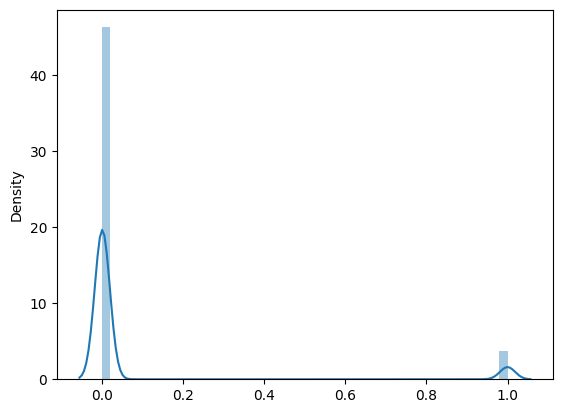

In [193]:
sns.distplot(new_df_tmp.WORK_NAME_remont_kryshi.values)
np.median(new_df_tmp.WORK_NAME_remont_kryshi.values)

In [209]:
df_houses_by_unom = df_multi_houses_characts_tmp.loc[df_multi_houses_characts_tmp['unom'] == 20151]
df_houses_by_unom.head()

ID             NAME  PARENT_ID      LOGIN  dest ownership build_year reconst_year project_series floars entrances apartments total_area living_area nonliving_area construction_volume depreciation_object energyefficiency_class wall_material sign_building_failure passenger_elevators passenger_freight_elevators roof_cleaning   COL_781   unom type_social_object type_housing_stock status_MKD management_status_MKD freight_elevators reason_changing_status_MKD category_MKD
34  1501181.0  ivanteevskaia_1        0.0  404010001  None         0       1968            0       56183245      9         1         72       3140        3074             66                   0                   0                      0     179625102              22728486                   1                           0             0  22289201  20151                  0           42875644   58761330              45063584                 0                          0            0

In [208]:
incidents_by_unom = df_incidents_tmp.loc[df_incidents_tmp['unom'] == 2404461]
incidents_by_unom.head()

incident_name source          address     unom  external_create_date_year  external_create_date_month  external_create_date_day  done_date_year  done_date_month  done_date_day  close_date_year  close_date_month  close_date_day
1  otklonenie_gvs_nizhe_normy_nochiu_monitoring  ASUPR  dmitrievskogo_5  2404461                       2022                           2                        20            1970                1              1           2022.0               4.0             4.0
2    otklonenie_gvs_nizhe_normy_dnem_monitoring  ASUPR  dmitrievskogo_5  2404461                       2022                           3                         7            1970                1              1           2022.0               3.0             9.0
3                   temperatura_gvs_nizhe_normy  ASUPR  dmitrievskogo_5  2404461                       2022                           3                         5            1970                1              1           2022.0               3.0             5.0
4                   temperatura_gvs_nizhe_normy  ASUPR  dmitrievskogo_5  2404461                       2022                           2                        18            1970                1              1           2022.0               2.0            18.0
5                otsutstvuet_tsirkuliatsiia_gvs  ASUPR  dmitrievskogo_5  2404461                       2022                           2                        18            1970                1              1           2022.0               2.0            18.0